# Block 7 Übung 5: Exploration von Messdaten gegenüber Diagnosen

## Bibliotheken & Konfiguration

In [1]:
packages <- c("readr", "dplyr", "tidyr", "icd.data", "ggplot2", "stringr")
install.packages(setdiff(packages, rownames(installed.packages())))
lapply(packages, require, character.only = TRUE)

base_url <- "https://raw.githubusercontent.com/ganslats/TMF-School-Datenanalyse-Visualisierung/master/Rohdaten/"

Lade nötiges Paket: readr

Lade nötiges Paket: dplyr


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union


Lade nötiges Paket: tidyr

Lade nötiges Paket: icd.data

Lade nötiges Paket: ggplot2

Lade nötiges Paket: stringr



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

## MIMIC III-Basisdaten laden

In [2]:
# Patientenstammdaten laden
mimic.patients.raw <- read_csv(paste(base_url, "mimic-iii-demo/PATIENTS.csv", sep=""),
                               col_types = cols(row_id = col_integer(), subject_id = col_integer(), gender = col_character(), dob = col_datetime(format = ""), dod = col_datetime(format = ""), dod_hosp = col_datetime(format = ""), dod_ssn = col_datetime(format = ""), expire_flag = col_double()))

# Behandlungsfälle laden
mimic.admissions.raw <- read_csv(paste(base_url, "mimic-iii-demo/ADMISSIONS.csv", sep=""),
                                 col_types = cols(  row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), admittime = col_datetime(format = ""), dischtime = col_datetime(format = ""), deathtime = col_datetime(format = ""), admission_type = col_character(), admission_location = col_character(), discharge_location = col_character(), insurance = col_character(), language = col_character(), religion = col_character(), marital_status = col_character(), ethnicity = col_character(), edregtime = col_datetime(format = ""), edouttime = col_datetime(format = ""), diagnosis = col_character(), hospital_expire_flag = col_double(), has_chartevents_data = col_double()))

# Intensivaufenthalte laden
mimic.icustays.raw <- read_csv(paste(base_url, "mimic-iii-demo/ICUSTAYS.csv", sep=""),
                               col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), icustay_id = col_integer(), dbsource = col_character(), first_careunit = col_character(), last_careunit = col_character(), first_wardid = col_double(), last_wardid = col_double(), intime = col_datetime(format = ""), outtime = col_datetime(format = ""), los = col_double()))


## MIMIC III-Diagnosen laden & Bezeichner ergänzen

In [3]:
# Diagnosen laden
mimic.diagnoses.raw <- read_csv(paste(base_url, "mimic-iii-demo/DIAGNOSES_ICD.csv", sep=""),
                                col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), seq_num = col_integer(), icd9_code = col_character()))

# Diagnosebezeichner laden
mimic.d_icd_diagnoses.raw <- read_csv(paste(base_url, "mimic-iii-demo/D_ICD_DIAGNOSES.csv", sep=""),
                                      col_types = cols(row_id = col_integer(), icd9_code = col_character(), short_title = col_character(), long_title = col_character()))

# Diagnosebezeichner hinzufügen
mimic.diagnoses.annotated <- mimic.diagnoses.raw %>% inner_join(mimic.d_icd_diagnoses.raw %>% select(icd9_code, short_title, long_title), by = "icd9_code")

## MIMIC III-Labordaten laden & Bezeichner ergänzen

In [4]:
# Laborbefunde laden
mimic.labevents.raw <- read_csv(paste(base_url, "mimic-iii-demo/LABEVENTS.csv", sep=""),
                                col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), itemid = col_integer(), charttime = col_datetime(format = ""), value = col_character(), valuenum = col_double(), valueuom = col_character(), flag = col_character()))

# Bezeichner laden
mimic.d_labitems.raw <- read_csv(paste(base_url, "mimic-iii-demo/D_LABITEMS.csv", sep=""),
                                 col_types = cols(row_id = col_integer(), itemid = col_integer(), label = col_character(), fluid = col_character(), category = col_character(), loinc_code = col_character()))

# Bezeichner hinzufügen
mimic.labevents.annotated <- mimic.labevents.raw %>% 
  inner_join(mimic.d_labitems.raw %>% select(itemid, label, fluid, category, loinc_code), by = "itemid")

## ICD9-Diagnosekatalog (inkl. Kapitel-Hierarchie) laden

In [5]:
# ICD9-Hierarchie aus Package in ein Tibble überführen
icd9.hierarchy.raw <- icd9cm_hierarchy

# Datentypanpassung der "code"-Spalte, um einen Join mit den MIMIC-Diagnosen zu ermöglichen
icd9.hierarchy.raw$icd9_code <- as.character(icd9.hierarchy.raw$code)

## Hauptdiagnosen auf ICD9-Kapitel abbilden und den Labordaten zuordnen

Hinweis: Laut Dokumentation wird die Hauptdiagnose in der Regel "als erstes" angegeben und ist über die Spalte seq_num == 1 selektierbar

In [6]:
diagnoses_labs <- mimic.diagnoses.raw %>% 
    # Hauptdiagnose filtern
    filter(seq_num == 1) %>%
    # nur Spalten Fallnummer und ICD9-Code selektieren
    select(hadm_id, icd9_code) %>%
    # ICD9-Kapitel aus Hierarchie ergänzen
    inner_join(icd9.hierarchy.raw %>% select(icd9_code, chapter), by = "icd9_code") %>%
    # Mehrfachdiagnosen entfernen
    distinct() %>%
    # Relevante Spalten der Laborbefunde hinzufügen
    inner_join(mimic.labevents.annotated %>% select(hadm_id, loinc_code, label, fluid, valuenum, valueuom), by = "hadm_id")
head(diagnoses_labs)

hadm_id,icd9_code,chapter,loinc_code,label,fluid,valuenum,valueuom
<int>,<chr>,<fct>,<chr>,<chr>,<chr>,<dbl>,<chr>
142345,99591,Injury And Poisoning,32693-4,Lactate,Blood,4.4,mmol/L
142345,99591,Injury And Poisoning,1742-6,Alanine Aminotransferase (ALT),Blood,9.0,IU/L
142345,99591,Injury And Poisoning,1751-7,Albumin,Blood,3.4,g/dL
142345,99591,Injury And Poisoning,6768-6,Alkaline Phosphatase,Blood,167.0,IU/L
142345,99591,Injury And Poisoning,1863-0,Anion Gap,Blood,20.0,mEq/L
142345,99591,Injury And Poisoning,1920-8,Asparate Aminotransferase (AST),Blood,40.0,IU/L


## Laboranalyte für Kreatinin heraussuchen

In [7]:
# Verfügbare Analyte & Befunde zum Kreatinin anzeigen
mimic.labevents.annotated %>%
    filter(grepl("Creatinine", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
"Albumin/Creatinine, Urine",Urine,14958-3,3
"Amylase/Creatinine Ratio, Urine",Urine,34235-2,1
Creatinine,Blood,2160-0,2175
"Creatinine, Ascites",Ascites,12191-3,5
"Creatinine, Body Fluid",Other Body Fluid,12190-5,1
"Creatinine, Pleural",Pleural,14399-0,1
"Creatinine, Urine",Urine,2161-8,97
Protein/Creatinine Ratio,Urine,2890-2,12


## Kreatininbefunde gegenüber den ICD9-Kapiteln darstellen

Hinweise:
* es gibt einen Ausreißer, dessen Befund eher in den Wertebereich von Kreatininmessungen im Urin fällt (Fehldokumentation?); dieser wird durch ein entsprechendes Filterkriterium im data-segment der `ggplot()`-Funktion entfernt. **Wichtig**: nicht vergessen, dieses Filterkriterium bei der Wiederverwendung des Codefragments für andere Analyte herauszunehmen oder ggf. anzupassen.
* mit str `str_wrap()`-Funktion aus dem Package `stringr`können lange Bezeichner automatisch umgebrochen werden, um die Darstellung lesbarer zu machen b zw. den nötigen Platz für die Achsenbeschriftung/Legende zu reduzieren

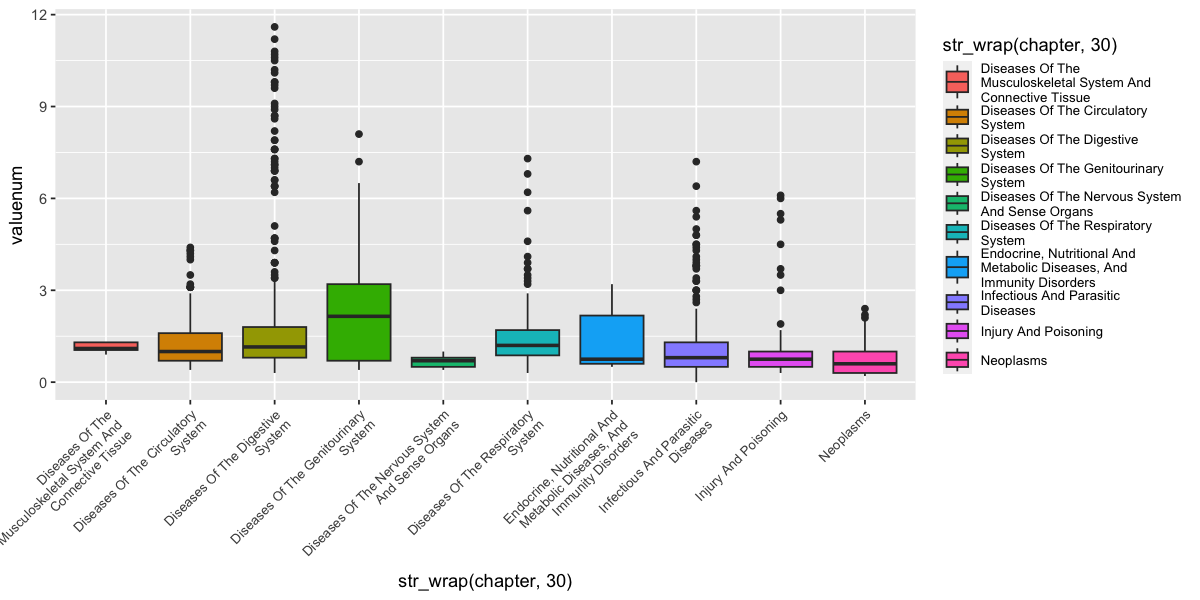

In [8]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = diagnoses_labs %>% filter(label == "Creatinine", 
                                        valuenum < 100),  # Ausfilterung eines einzelnen Ausreißers
       aes(x = str_wrap(chapter, 30), y = valuenum, fill = str_wrap(chapter, 30))) +
  geom_boxplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        legend.text = element_text(size = 8))

## Aufgabe: Finden & visualisieren Sie Laborbefunde, bei denen Sie Unterschiede zwischen den verschiedenen ICD9-Diagnosekapiteln erwarten würden!

Hier können Sie das Wissen aus dem Abschnitt 4, Demo 2 (Daten abfragen mit Tidyverse) und dem Abschnitt 6, Demo 1 (Daten visualisieren, Diagramme) anwenden.
* zugehörige Notebooks: [teil-4-demo-02-abfragen-tidyverse.ipynb](https://github.com/ganslats/TMF-School-Datenanalyse-Visualisierung/blob/main/Notebooks/teil-4-demo-02-abfragen-tidyverse.ipynb), [teil-6-demo-01-visualisieren-diagramme.ipynb](https://github.com/ganslats/TMF-School-Datenanalyse-Visualisierung/blob/main/Notebooks/teil-6-demo-01-visualisieren-diagramme.ipynb)
* nutzen Sie gerne auch das [ggplot2-Cheat Sheet von RStudio](https://github.com/rstudio/cheatsheets/raw/master/data-visualization-2.1.pdf)

Hinweise:
* aufgrund der niedrigen Fallzahl & des komplexen Patientenguts (Intensivstation), gerade auch durch mehrere parallel bestehende Diagnosen, werden die Ergebnisse häufig eher heterogen ausfallen - es geht hier mehr um die grundsätzliche Vorgehensweise
* die Auswertung kann zusätzlich auch dadurch verzerrt sein, dass Laboruntersuchungen erkrankungs- & symptombezogen angefordert werden und daher ggf. bestimmte Analyte bei Patient:innen in anderen ICD9-Diagnosekapiteln nicht oder nur selten bestimmt werden
* es sollten deshalb Analyte ausgewählt werden, die häufig angefordert wurden

## Visualisierung Troponin T vs. ICD9-Diagnosekapitel

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
Troponin I,Blood,10839-9,14
Troponin T,Blood,6598-7,288


Warning message:
“Removed 55 rows containing non-finite values (`stat_boxplot()`).”


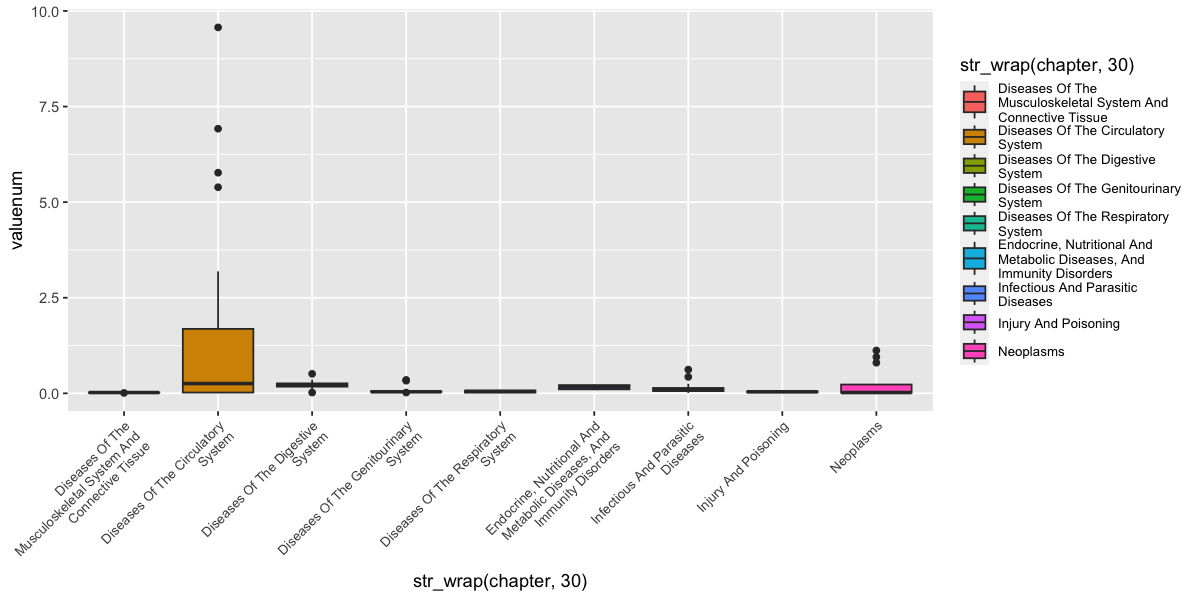

In [9]:
# Verfügbare Analyte & Befunde zum Analyt anzeigen
mimic.labevents.annotated %>%
    filter(grepl("Troponin", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

# Visualisierung zum Analyt
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = diagnoses_labs %>% filter(label == "Troponin T"),
       aes(x = str_wrap(chapter, 30), y = valuenum, fill = str_wrap(chapter, 30))) +
  geom_boxplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        legend.text = element_text(size = 8))

## Visualisierung Kalium (Potassium) vs. ICD9-Diagnosekapitel

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
Potassium,Blood,2823-3,2279
"Potassium, Body Fluid",Other Body Fluid,2821-7,1
"Potassium, Urine",Urine,2828-2,26
"Potassium, Whole Blood",Blood,6298-4,256


Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”


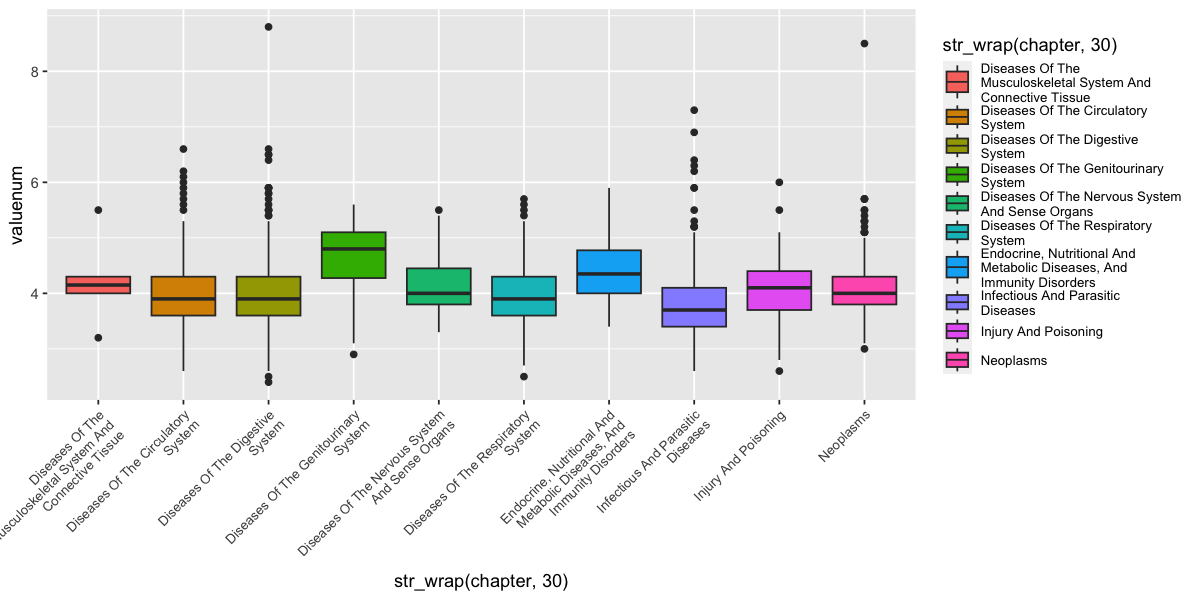

In [10]:
# Verfügbare Analyte & Befunde zum Analyt anzeigen
mimic.labevents.annotated %>%
    filter(grepl("Potassium", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

# Visualisierung zum Analyt
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = diagnoses_labs %>% filter(label == "Potassium"),
       aes(x = str_wrap(chapter, 30), y = valuenum, fill = str_wrap(chapter, 30))) +
  geom_boxplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        legend.text = element_text(size = 8))

## Visualisierung Gesamt-Bilirubin vs. ICD9-Diagnosekapitel

label,fluid,loinc_code,n
<chr>,<chr>,<chr>,<int>
Bilirubin,Urine,5770-3,284
"Bilirubin, Direct",Blood,1968-7,60
"Bilirubin, Indirect",Blood,1971-1,54
"Bilirubin, Total",Blood,1975-2,629
"Bilirubin, Total, Ascites",Ascites,14422-0,5
"Bilirubin, Total, Body Fluid",Other Body Fluid,1974-5,1
"Bilirubin, Total, Pleural",Pleural,14421-2,2


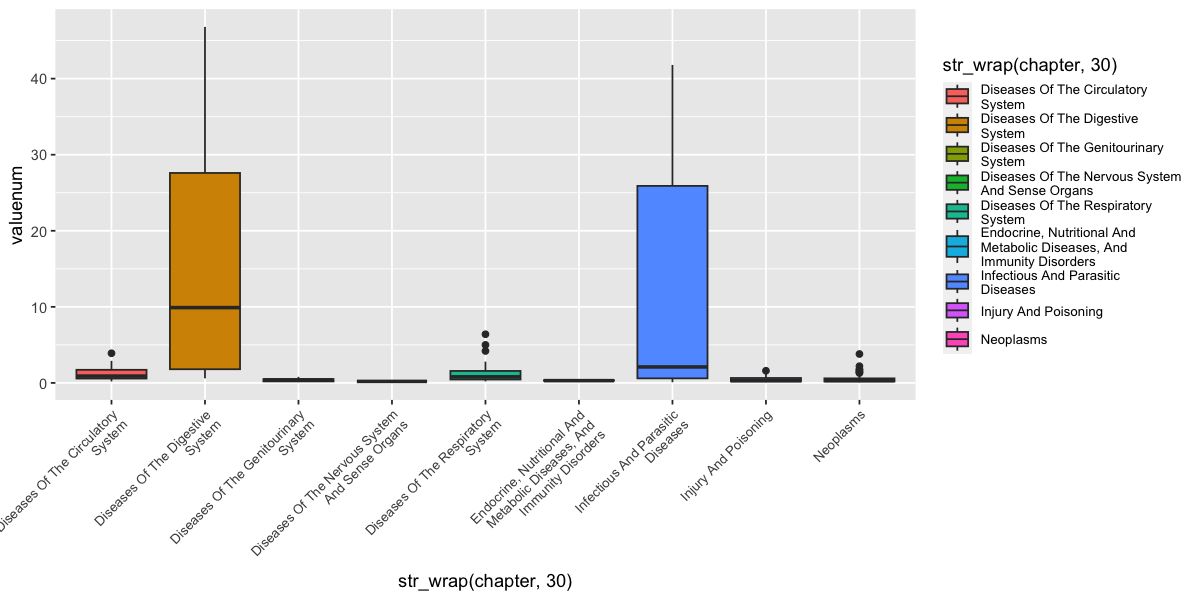

In [11]:
# Verfügbare Analyte & Befunde zum Analyt anzeigen
mimic.labevents.annotated %>%
    filter(grepl("Bilirubin", label)) %>%
    group_by(label, fluid, loinc_code) %>%
    summarize(n = n(), .groups = "keep")

# Visualisierung zum Analyt
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = diagnoses_labs %>% filter(label == "Bilirubin, Total"),
       aes(x = str_wrap(chapter, 30), y = valuenum, fill = str_wrap(chapter, 30))) +
  geom_boxplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
        legend.text = element_text(size = 8))